In [ ]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# package import
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import KFold

import os
import re
import glob
import cv2
import argparse
import random
import multiprocessing
import string

In [ ]:
# 중요 변수 사전 저장
configs = {
    'DIR_NAME': '...dir/data',
    'ROOT_DIR': '...dir/data/label_csv/',
    'fold' : [0,1,2,3,4]
}
query = '/*/*/*/*.jpg'

In [ ]:
# 시드 고정 일괄 적용
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(2021)

In [ ]:
# 파일 경로 얻기
def read_image_file(input_path, query):
    files_paths = glob.glob(input_path + query)
    return files_paths

In [ ]:
# 랜드마크 갯수 확인
def get_class_lists(file_paths):
    class_lists = set([file_paths[i].split('/')[-2] for i in range(len(file_paths))])
    return list(class_lists)

In [ ]:
# 분석에 필요한 정보만 추출
def generate_dict(file_paths, classes):
    ids = []
    landmark_ids = []
    path = []
    for i in tqdm(range(len(file_paths))):
        try:
            landmark_ids.append(classes.index(file_paths[i].split('/')[-2]))
            ids.append(file_paths[i].split('/')[-1][:-4])
            path.append(file_paths[i])
        except:
            pass

    gen_dict = {'id': ids,
             'landmark_id': landmark_ids,
             'path': path}    
    return gen_dict

In [ ]:
# 파일 경로를 저장하고 이를 활용하여 랜드마크 갯수 확인
train_file_paths = read_image_file(configs['DIR_NAME'], query)
classes = get_class_lists(train_file_paths)

print(f"Total num of data: {len(train_file_paths)}")
print(f"Total num of classes: {len(classes)}")

Total num of data: 1480
Total num of classes: 77


In [ ]:
# 파일 명, 랜드마크 id, 파일 경로 정보를 담은 데이터프레임 생성
train_df = generate_dict(train_file_paths, classes)
train_df = pd.DataFrame(train_df)
train_df.head()

100%|██████████| 1480/1480 [00:00<00:00, 266739.86it/s]


,id,landmark_id,path
0,5D입체영상관_002_36956758,32,/content/drive/MyDrive/Colab Notebooks/Study/C...
1,5D입체영상관_013_36956781,32,/content/drive/MyDrive/Colab Notebooks/Study/C...
2,5D입체영상관_004_36956761,32,/content/drive/MyDrive/Colab Notebooks/Study/C...
3,5D입체영상관_010_36956776,32,/content/drive/MyDrive/Colab Notebooks/Study/C...
4,5D입체영상관_005_36956767,32,/content/drive/MyDrive/Colab Notebooks/Study/C...


In [ ]:
# 랜드마크 개수 재확인
print(f"number of classes : {len(train_df['landmark_id'].unique())}")

number of classes : 77


In [ ]:
# Cross validation 진행을 위해 데이터에 랜덤으로 id값 부여(0 ~ 4)
kfold = KFold(n_splits=len(configs['fold']), random_state=2021, shuffle=True)
kfold.get_n_splits(train_df)

for i, (train_index, test_index) in enumerate(kfold.split(train_df)):
    train_df.loc[test_index, 'val_idx'] = i

for fold in configs['fold']:
    print(fold)
    train_df_fold = train_df.loc[train_df['val_idx'] != fold].reset_index(drop=True)
    test_df = train_df.loc[train_df['val_idx'] == fold].reset_index(drop=True)
    
    train_df_fold.to_csv(configs['ROOT_DIR'] + f'train_labels_{fold}.csv', index=False)
    test_df.to_csv(configs['ROOT_DIR'] + f'test_labels_{fold}.csv', index=False)
    
    print(f'train_df: {len(train_df_fold)}')
    print(f'test_df: {len(test_df)}')
train_df.to_csv(configs['ROOT_DIR'] + f'train_labels_fold.csv', index=False)

0
train_df: 1184
test_df: 296
1
train_df: 1184
test_df: 296
2
train_df: 1184
test_df: 296
3
train_df: 1184
test_df: 296
4
train_df: 1184
test_df: 296


In [ ]:
# CV label값을 2로 지정한 데이터프레임 가져와 클래스 수 확인(반복문 결과 검토)
train = pd.read_csv('...dir')
test = pd.read_csv('...dir')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


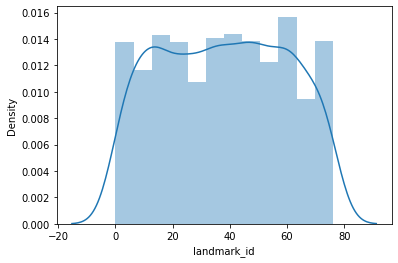

In [ ]:
# EDA - train data의 랜드마크 별 이미지 비율 분포 확인
sns.distplot(train_df['landmark_id']);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


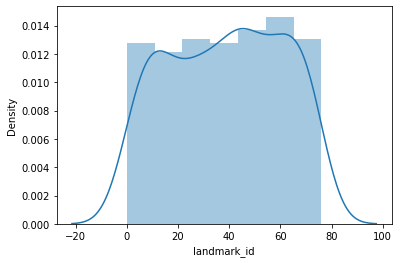

In [ ]:
# EDA - test data의 랜드마크 별 이미지 비율 분포 확인
sns.distplot(test_df['landmark_id']);

In [ ]:
# ImageResize
def resize_image_file(file_names, save_path, train=True):
    for i in tqdm(range(len(file_names))):
        img = cv2.imread(file_names[i])
        img = cv2.resize(img, (384 ,384))
        if train:
            try:
                if not(os.path.isdir(save_path + 'train/' + file_names[i].split('/')[-2])):
                    os.makedirs(os.path.join(save_path + 'train/' + file_names[i].split('/')[-2]))
            except OSError as e:
                if e.errno != errno.EEXIST:
                    print("Failed to create train directory!!!!!")
                    raise
                    
            if not(os.path.isfile(save_path + 'train/' + file_names[i].split('/')[-2] + '/' + os.path.splitext(file_names[i].split('/')[-1])[0] + '.jpg')):                    
                    cv2.imwrite(os.path.join(save_path + 'train/' + file_names[i].split('/')[-2] + '/' + os.path.splitext(file_names[i].split('/')[-1])[0] + '.jpg'), img)
            else:
                pass

In [ ]:
# 경로 설정
file_path = "...dir/data"
save_path = "...dir/data/train/resize/"

In [ ]:
# ImageResize 진행
file_names = read_image_file(file_path, query)
resize_image_file(file_names, save_path, train=True)

100%|██████████| 1480/1480 [18:31<00:00,  1.33it/s]
